In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch #https://github.com/facebookresearch/esm

from Bio.PDB import PDBParser, PPBuilder
import pcmap
import math

In [7]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/source_data.csv")
interaction_df = interaction_df[(interaction_df["A_seq"].notna())& (interaction_df["B_seq"].notna())].reset_index(drop=True)
interaction_df = interaction_df[interaction_df["target_chains"] == "[\"B\"]"]
interaction_df = interaction_df[interaction_df["B_seq"].notna()].reset_index(drop=True)
cols_remain = ["binder_id", "target_id", "binder_chain", "target_chains", "binder", "A_seq", "B_seq"]
interaction_df = interaction_df[cols_remain]
# interaction_df = interaction_df.drop(columns=["binder_chain", "target_chains"])

# Adding new target id
dfu = interaction_df.drop_duplicates(["target_id", "B_seq"])
dfu[dfu.target_id == "EGFR"].B_seq.tolist()
targets_Dict, target_tracking = {}, {target:int(2) for target in dfu.target_id.unique()}

for idx, target_id in enumerate(dfu.target_id):
    if target_id not in targets_Dict.keys():
        targets_Dict[target_id] = dfu.iloc[idx]["B_seq"]
    else:
        target_id_new = f"{target_id}_{target_tracking[target_id]}"
        targets_Dict[target_id_new] = dfu.iloc[idx]["B_seq"]
        count = target_tracking[target_id]
        target_tracking[target_id] = count + 1

interaction_df['target_id_mod'] = interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
cnt = interaction_df.groupby('target_id_mod').cumcount() + 1
interaction_df['target_binder_ID'] = interaction_df['target_id_mod'].astype(str) + '_' + cnt.astype(str)
interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod,target_binder_ID
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4
...,...,...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65


In [10]:
seq = interaction_df["A_seq"].sample(n=1, random_state=14).item()
binder_id = interaction_df["binder_id"].sample(n=1, random_state=14).item()
pdb_path = f"/work3/s232958/data/meta_analysis/input_pdbs/input_pdbs/{binder_id}.pdb"
print("Sequence:", seq, len(seq))

Sequence: RAELEAAAEAARAAAAARGHRMEYWFWKGTVAVLVSPRTPEVEALLAELRAAAAAAGYGLSVGAL 65


In [11]:
pdb_path

'/work3/s232958/data/meta_analysis/input_pdbs/input_pdbs/Trka_binder_AF2_36.pdb'

#### Contact map computed using `../data/RAEL.pdb` structure

Contact map size: (65, 65)


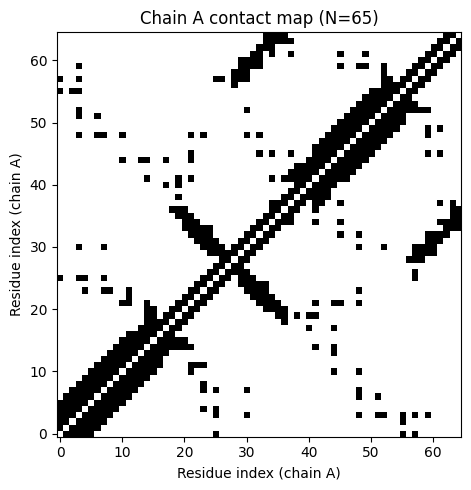

In [27]:
cmap = pcmap.contactMap(pdb_path)

# Collect residue IDs from chain A only
resids = []
for pos_dict in cmap["data"]:
    if pos_dict["root"]["chainID"] == "A":
        for inter in pos_dict["partners"]:
            if inter["chainID"] == "A":     # ensure partner is also chain A
                resids.append(int(pos_dict["root"]["resID"]))
                resids.append(int(inter["resID"]))

uniq_resids = sorted(set(resids))
idx = {rid: i for i, rid in enumerate(uniq_resids)}
N = len(uniq_resids)

# Fill symmetric binary contact map (chain A only)
M = np.zeros((N, N), dtype=np.uint8)
for pos_dict in cmap["data"]:
    if pos_dict["root"]["chainID"] == "A":
        i_res = int(pos_dict["root"]["resID"])
        if i_res not in idx:
            continue
        i = idx[i_res]

        for inter in pos_dict["partners"]:
            if inter["chainID"] == "A":      # partner must be chain A
                j_res = int(inter["resID"])
                if j_res not in idx:
                    continue
                j = idx[j_res]
                M[i, j] = 1
                M[j, i] = 1

print("Contact map size:", M.shape)

plt.figure(figsize=(5,5))
plt.imshow(M, origin="lower", interpolation="nearest", cmap="binary")
plt.title(f"Chain A contact map (N={N})")
plt.xlabel("Residue index (chain A)")
plt.ylabel("Residue index (chain A)")
plt.tight_layout()
plt.show()

#### Dinstances between Cα–Cα computed using `../data/RAEL.pdb` and `PDBParser()`

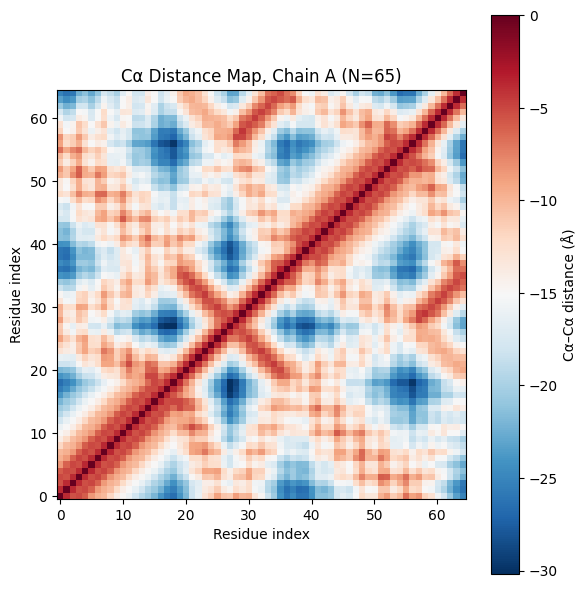

In [33]:

def ca_distance_matrix(pdb_path, chain_id="A"):
    struct = PDBParser(QUIET=True).get_structure("s", pdb_path)

    cas = []
    labels = []

    # Use only the first model
    model = next(struct.get_models())

    for chain in model:
        if chain_id is not None and chain.id != chain_id:
            continue  # skip non-A chains

        for res in chain:
            # Skip heteroatoms, water, or residues missing CA
            if res.id[0] != " " or "CA" not in res:
                continue

            cas.append(res["CA"].coord)
            labels.append((chain.id, res.get_resname(), res.id[1], res.id[2]))

        # If we specified chain A, stop after processing it
        if chain_id is not None:
            break

    # Safety check
    if len(cas) == 0:
        raise ValueError(f"No CA atoms found for chain {chain_id} in {pdb_path}")

    X = np.asarray(cas)                     # [N, 3]
    D = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=-1)  # [N, N]

    return D, labels


# ---- Use chain A only ----
D, labels = ca_distance_matrix(pdb_path, chain_id="A")

plt.figure(figsize=(6,6))
plt.imshow(-D, origin="lower", interpolation="nearest", cmap="RdBu_r")
plt.colorbar(label="Cα–Cα distance (Å)")
plt.title(f"Cα Distance Map, Chain A (N={D.shape[0]})")
plt.xlabel("Residue index")
plt.ylabel("Residue index")
plt.tight_layout()
plt.show()

### Loading ESM2 model

In [15]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
batch_converter = alphabet.get_batch_converter()
model.eval()
model

Using cache found in /zhome/c9/0/203261/.cache/torch/hub/facebookresearch_esm_main


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

### Contact map form the ESM model:

`contacts = model(batch_tokens, repr_layers=[L], return_contacts=True)["contacts"][0]`

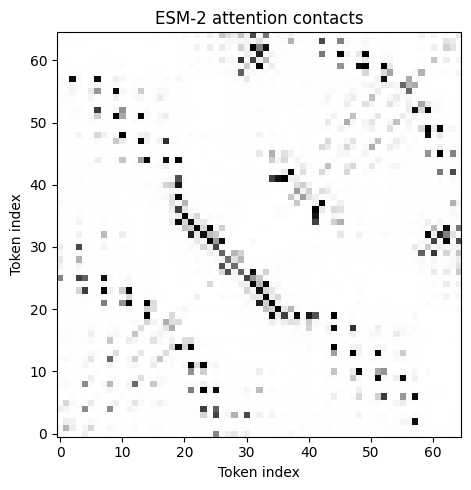

In [31]:
data = [("protein1", seq)]  # <- single sequence

# Make batch
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)  # tensor([L_plus_special])

with torch.no_grad():
    # use the model's last layer automatically
    L = model.num_layers
    out = model(batch_tokens, repr_layers=[L], return_contacts=True)

token_reps = out["representations"][L]      # shape: [1, T, H]
tokens_len = int(batch_lens[0])             # includes BOS/EOS

# Per-sequence embedding (average of residue tokens; skip BOS/EOS)
seq_emb = token_reps[0, 1:tokens_len-1].mean(0)  # shape: [H]

# Contact map (trim to actual tokens_len if needed)
contacts = out["contacts"][0]               # shape: [T, T]
contacts = contacts[:tokens_len, :tokens_len]

plt.figure(figsize=(5,5))
plt.imshow(contacts, origin="lower", interpolation="nearest", cmap="binary")
plt.title("ESM-2 attention contacts")
plt.xlabel("Token index")
plt.ylabel("Token index")
plt.tight_layout()
plt.show()

### Comapring all 3: cmap vs -D vs contacts

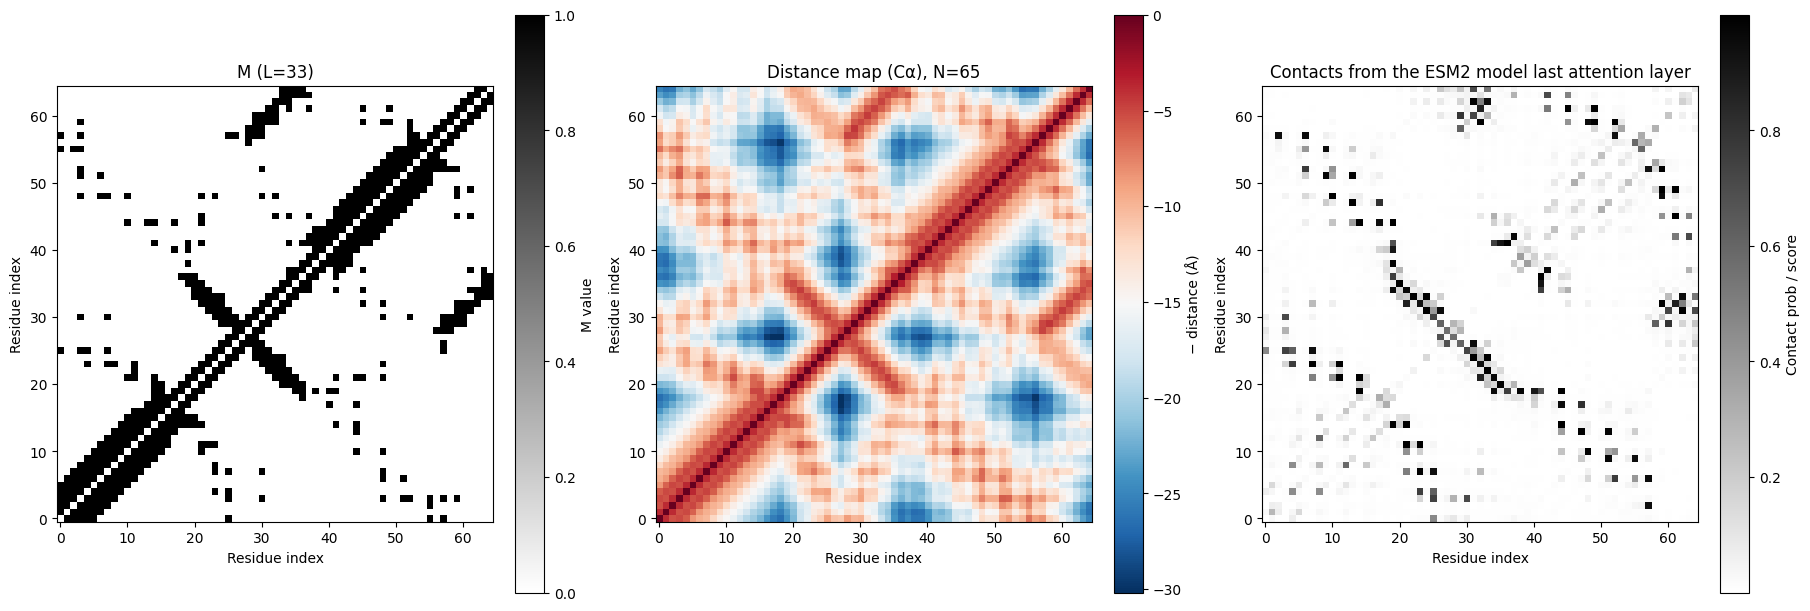

In [34]:
# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# M
im0 = axes[0].imshow(M, origin="lower", interpolation="nearest", cmap="binary")
axes[0].set_title(f"M (L={model.num_layers})")
axes[0].set_xlabel("Residue index"); axes[0].set_ylabel("Residue index")
cb0 = fig.colorbar(im0, ax=axes[0])
cb0.set_label("M value")

# D (plotted as -D per your example)
im1 = axes[1].imshow(-D, origin="lower", interpolation="nearest", cmap="RdBu_r")
axes[1].set_title(f"Distance map (Cα), N={D.shape[0]}")
axes[1].set_xlabel("Residue index"); axes[1].set_ylabel("Residue index")
cb1 = fig.colorbar(im1, ax=axes[1])
cb1.set_label("− distance (Å)")

# Contacts
im2 = axes[2].imshow(contacts, origin="lower", interpolation="nearest", cmap="binary")
axes[2].set_title("Contacts from the ESM2 model last attention layer")
axes[2].set_xlabel("Residue index"); axes[2].set_ylabel("Residue index")
cb2 = fig.colorbar(im2, ax=axes[2])
cb2.set_label("Contact prob / score")

plt.show()

In [35]:
batch_tokens # encoding of amino acids used

tensor([[ 0, 10,  5,  9,  4,  9,  5,  5,  5,  9,  5,  5, 10,  5,  5,  5,  5,  5,
         10,  6, 21, 10, 20,  9, 19, 22, 18, 22, 15,  6, 11,  7,  5,  7,  4,  7,
          8, 14, 10, 11, 14,  9,  7,  9,  5,  4,  4,  5,  9,  4, 10,  5,  5,  5,
          5,  5,  5,  6, 19,  6,  4,  8,  7,  6,  5,  4,  2]])

- `batch_tokens` is a `torch.LongTensor` shaped [1, T] (batch of 1).
- Index 0 (0) is the `BOS` token (begin-of-sequence).
- Last index (2) is the `EOS` token (end-of-sequence).
- Everything in between are amino-acid token IDs.
- In `ESM-2`, `alphabet.cls_idx == 0`, `alphabet.padding_idx == 1`, `alphabet.eos_idx == 2`.

In [36]:
# decode ID --> letter
T = int((batch_tokens != alphabet.padding_idx).sum())
ids = batch_tokens[0, 1:T-1].tolist()             # drop BOS/EOS
letters = [alphabet.get_tok(i) for i in ids]      # map IDs to tokens
seq_back = "".join(letters)
print("T:", T) # kength of the protein sequence + BOS/EOS, i.e., batch tokens 0, 2
print("Decoded residues:", seq_back)

T: 67
Decoded residues: RAELEAAAEAARAAAAARGHRMEYWFWKGTVAVLVSPRTPEVEALLAELRAAAAAAGYGLSVGAL


In [37]:
with torch.no_grad():
    repr_layers = list(range(model.num_layers + 1))
    out = model(batch_tokens,
                repr_layers=repr_layers,
                return_contacts=True) 

out.keys()
# out["representations"] # embeddings
# out["attentions"] # all the attentions: 33 layers, 20 heads
# out["contacts"] # contact map

dict_keys(['logits', 'representations', 'attentions', 'contacts'])

In [38]:
out["attentions"].shape

# torch.Size([ 1,   33,   20,   73,   73 ])
#              │     │     │      │     └── src_len  (keys)
#              │     │     │      └──────── tgt_len  (queries)
#              │     │     └─────────────── n_heads  (per layer)
#              │     └───────────────────── n_layers (ESM-2 t33 → 33)
#              └─────────────────────────── batch_size (here 1)

torch.Size([1, 33, 20, 67, 67])

## Plotting last layer (33rd) all the heads separately to see which capture structural information

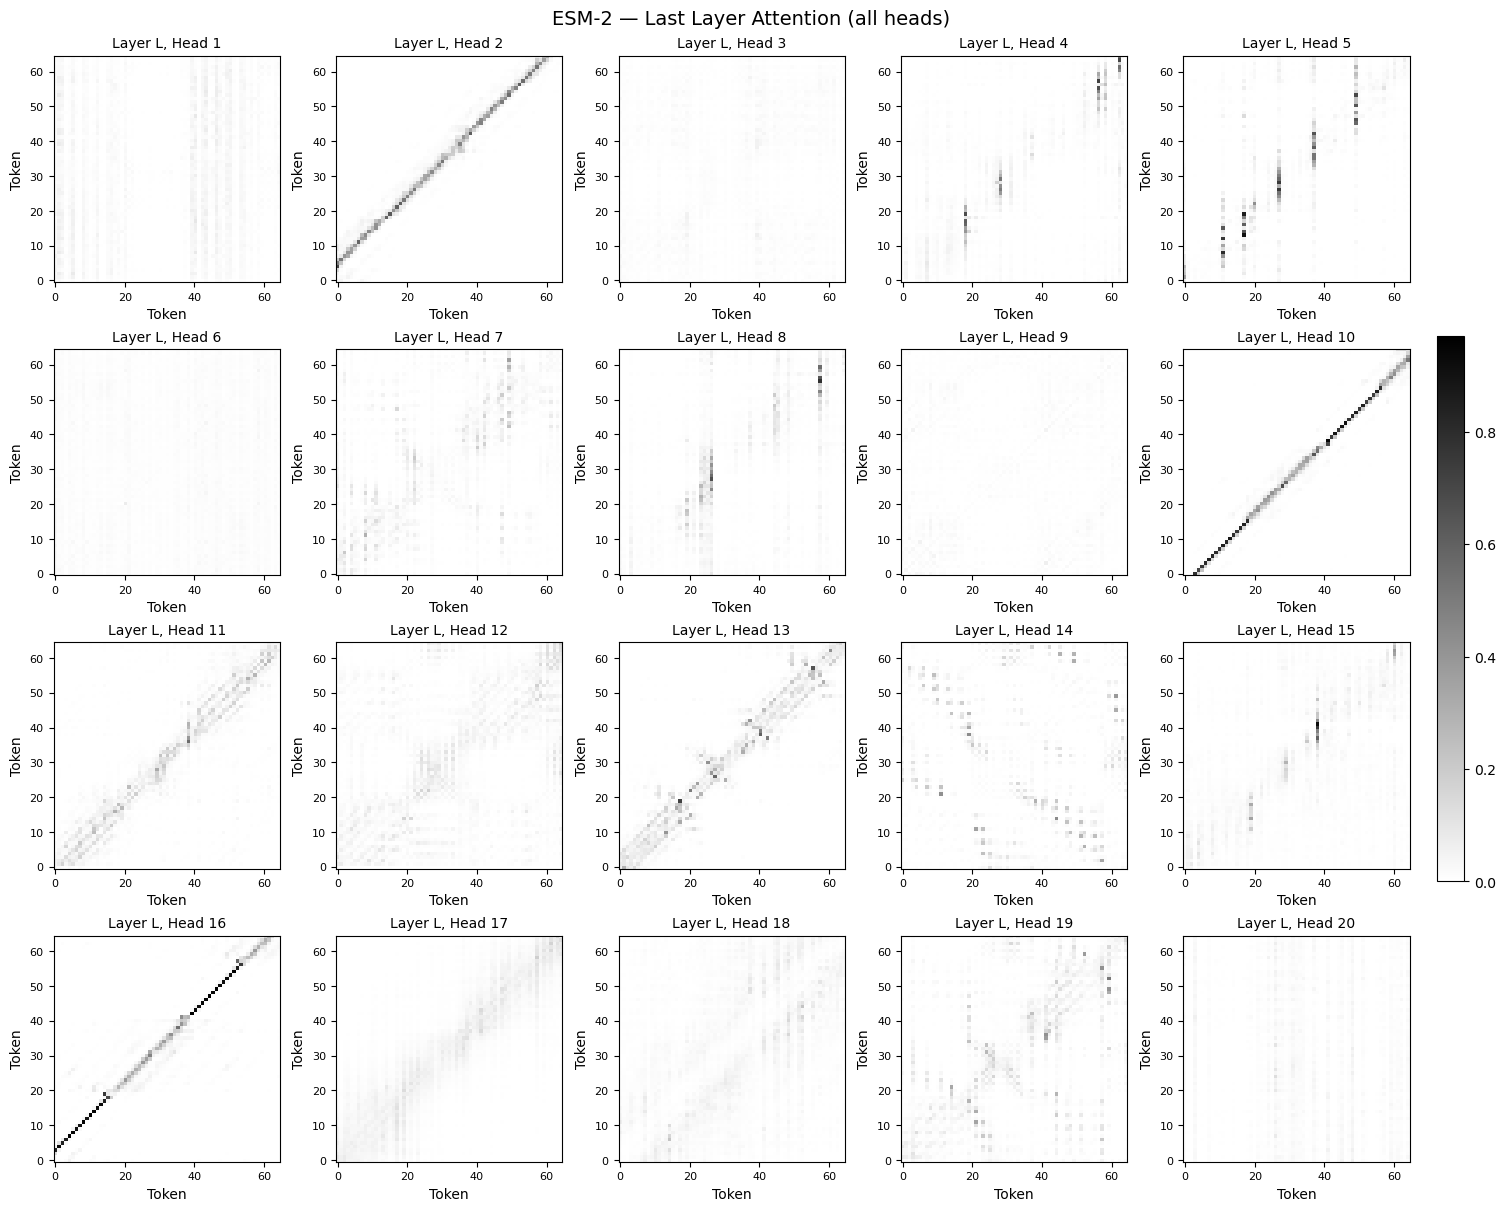

In [12]:
attentions = out["attentions"]
A = attentions[0, -1, :, :, :]   # [H, T', T']
H = A.shape[0]

# Drop BOS/EOS so it’s residue-only
T_valid = int((batch_tokens != alphabet.padding_idx).sum())
if T_valid >= 2:
    A = A[:, 1:-1, 1:-1]                       # [H, Lres, Lres]

# Plot all heads
cols = 5
rows = math.ceil(H / cols)
fig, axes = plt.subplots(rows, cols, figsize=(3.0*cols, 3.0*rows), constrained_layout=True)
axes = axes.ravel()

# Shared color scale (helps compare heads)
vmin = float(A.min())
vmax = float(A.max())

im0 = 0
for h in range(rows*cols):
    ax = axes[h]
    if h < H:
        M = A[h].detach().cpu().numpy()
        im0 = ax.imshow(M, origin="lower", interpolation="nearest", cmap="binary",
                        vmin=vmin, vmax=vmax)
        ax.set_title(f"Layer L, Head {h+1}", fontsize=10)
        ax.set_xlabel("Token"); ax.set_ylabel("Token")
        ax.tick_params(labelsize=8)
    else:
        ax.axis("off")

if im0 is not None:
    fig.colorbar(im0, ax=axes.tolist(), fraction=0.02, pad=0.02)

fig.suptitle("ESM-2 — Last Layer Attention (all heads)", fontsize=14)
plt.show()

### P@L

`P@L` means “precision at L” and it’s a standard way to score contact/interaction maps in proteins.
- Compute a score for each pair (i,j) with ∣i−j∣ above a minimum sequence separation (often ≥ 12 or ≥ 24 to count only **“long-range”**).
- Sort all pairs by predicted score (descending).
- Take the top L pairs.
- P@L = (# true contacts in top L) / L.

Differeces between the cutoffs:
- `P@L`: precision on the top L pairs (L = sequence length). This is the **most common** headline metric.
- `P@L/5`: precision using only the top L/5 pairs. **Very strict**—focuses on your very highest-confidence predictions.
- `P@L/2`: precision on the top L/2 pairs. A bit **broader than L/5**.
- `P@2L`: precision on the top 2L pairs. Tests performance **deeper into the ranked list**.

In [8]:
### True contacts (cutoff Cβ–Cβ < 8 Å, minimal seqeunce separation >= 24 Å)
# Cβ–Cβ < 8 & minimal seqeunce separation >= 24 Å means that the attoms are close in space but not close in sequence.
pdb_path = "/work3/s232958/data/RAEL.pdb"
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv").drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})
seq = interaction_df["binder_seq"].sample(n=1, random_state=14).item()
print("Sequence:", seq, len(seq))

Sequence: RAELEAAAEAARAAAAARGHRMEYWFWKGTVAVLVSPRTPEVEALLAELRAAAAAAGYGLSVGAL 65


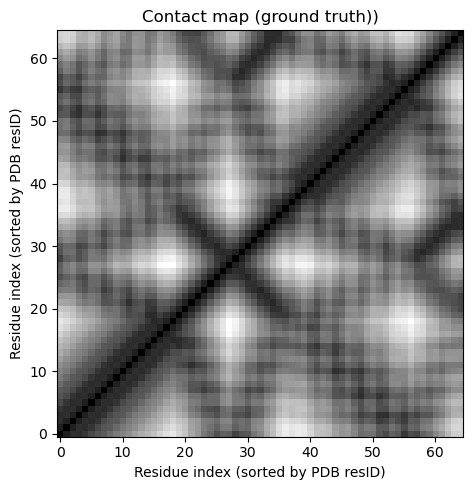

In [14]:
def true_contacts_ca(pdb_path, chain_id=None, cutoff=8.0, min_seq_sep=24):
    struct = PDBParser(QUIET=True).get_structure("s", pdb_path)
    # collect Cα coords
    coords = [res["CA"].coord for res in struct[0]["A"] if res.id[0] == " " and "CA" in res]
    X = np.asarray(coords) # [len, 3 coordinates of Cα]
    N = len(X) # length of the sequence
    D = np.sqrt(((X[:,None,:]-X[None,:,:])**2).sum(-1))  # [N,N] # Cα–Cα pairwise distance matrix
    
    T = (D <= cutoff) # True where the distance is smaller than cutoff
    # remove self and short-range    
    i,j = np.triu_indices(N, k=1)
    short = (np.abs(i-j) < min_seq_sep)
    T[i[short], j[short]] = False
    T[j[short], i[short]] = False

    plt.figure(figsize=(5,5))
    plt.imshow(-D, origin="lower", interpolation="nearest", cmap="binary")
    plt.title(f"Contact map (ground truth))")
    plt.xlabel("Residue index (sorted by PDB resID)")
    plt.ylabel("Residue index (sorted by PDB resID)")
    plt.tight_layout()
    plt.show()
    
    return D, T
    # D - original distances matrix
    # T - True were distanc eis lower than 8
D_ground_all_float, T_ground_bool = true_contacts_ca(pdb_path, chain_id=None, cutoff=8.0)

In [15]:
data = [("protein1", seq)]  # <- single sequence

# Make batch
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)  # tensor([L_plus_special])

with torch.no_grad():
    # use the model's last layer automatically
    L = model.num_layers
    out = model(batch_tokens, repr_layers=[L], return_contacts=True)

token_reps = out["representations"][L]      # shape: [1, T, H]
tokens_len = int(batch_lens[0])             # includes BOS/EOS

# Per-sequence embedding (average of residue tokens; skip BOS/EOS)
seq_emb = token_reps[0, 1:tokens_len-1].mean(0)  # shape: [H]

# Contact map (trim to actual tokens_len if needed)
contacts = out["contacts"][0]               # shape: [T, T]
attentions = out["attentions"][0, -1, :, :, :] # [H, T', T']
D_pred = contacts[:tokens_len, :tokens_len]

In [16]:
# interactions = {}

# for i, row in enumerate(D_pred):
#     for j, col in enumerate(row):
#         if j <= i:
#             continue  # skip diagonal and opposite (keep only upper triangle)
#         if abs(i - j) < 24:
#             continue  # enforce long-range only

#         key = f"{i},{j}"
#         # robust float extraction for torch / numpy
#         val = float(D_pred[i, j].item() if hasattr(D_pred[i, j], "item") else D_pred[i, j])

#         interactions[key] = val  # no duplicates now, upper triangle only

# sorted_interactions = sorted(interactions.items(), key=lambda x: x[1], reverse=True)
# sorted_interactions[:D_pred.shape[0]]

# for key, _ in sorted_interactions[:10]:
#     i, j = key.split(',')
#     print(i, j)

In [17]:
attentions[0].shape

torch.Size([67, 67])

In [18]:
def sorting_interactions(D_pred):
    interactions = {}
    for i, row in enumerate(D_pred):
        for j, col in enumerate(row):
            if j <= i:
                continue  # skip diagonal and opposite (keep only upper triangle)
            if abs(i - j) < 24:
                continue  # enforce long-range only
            key = f"{i},{j}"
            # robust float extraction for torch / numpy
            val = float(D_pred[i, j].item() if hasattr(D_pred[i, j], "item") else D_pred[i, j])
            interactions[key] = val  # no duplicates now, upper triangle only
    
    sorted_interactions = sorted(interactions.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_interactions

def precision_at_L(sorted_interactions, D_true, L):
    top = sorted_interactions[:L]
    if not top:
        return float('nan')
    hits = 0
    for key, _ in top:
        i, j = map(int, key.split(','))
        if bool(T_ground_bool[i, j]):
            hits += 1

    return round(hits / len(top), 3)

In [19]:
N = T_ground_bool.shape[0]         # sequence length
PatL = dict()

# Using contact map:
sorted_interactions = sorting_interactions(D_pred)
p_at_L    = precision_at_L(sorted_interactions, T_ground_bool, L=N)
p_at_L5   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//5))
p_at_L2   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//2))
p_at_2L   = precision_at_L(sorted_interactions, T_ground_bool, L=min(2*N, len(sorted_interactions)))
PatL["contact_map"] = [p_at_L, p_at_L5, p_at_L2, p_at_2L]

# Using heads (N=20)
for idx, head in enumerate(attentions):
    # print(head.shape)
    attn_residue = head[1:-1, 1:-1] # head is [67,67], drop CLS/EOS -> [65,65]
    # print(attn_residue.shape)
    sorted_interactions = sorting_interactions(attn_residue)
    p_at_L    = precision_at_L(sorted_interactions, T_ground_bool, L=N)
    p_at_L5   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//5))
    p_at_L2   = precision_at_L(sorted_interactions, T_ground_bool, L=max(1, N//2))
    p_at_2L   = precision_at_L(sorted_interactions, T_ground_bool, L=min(2*N, len(sorted_interactions)))
    PatL[f"head_{idx+1}"] = [p_at_L, p_at_L5, p_at_L2, p_at_2L]

In [20]:
# sort for p_at_L
print("Sorting for P @ L, top:5")
sorted_ = sorted(PatL.items(), key=lambda x: x[1][0], reverse=True)
for i in sorted_[:5]: print(i)
print("")

# sort for p_at_L5
print("Sorting for P @ L5, top:5")
sorted_ = sorted(PatL.items(), key=lambda x: x[1][1], reverse=True)
for i in sorted_[:5]: print(i)
print("")

# sort for p_at_L2
print("Sorting for P @ L2, top:5")
sorted_ = sorted(PatL.items(), key=lambda x: x[1][2], reverse=True)
for i in sorted_[:5]: print(i)
print("")

# sort for p_at_2L
print("Sorting for P @ 2L, top:5")
sorted_ = sorted(PatL.items(), key=lambda x: x[1][3], reverse=True)
for i in sorted_[:5]: print(i)
print("")

Sorting for P @ L, top:5
('contact_map', [0.354, 0.385, 0.438, 0.277])
('head_13', [0.354, 0.615, 0.531, 0.238])
('head_14', [0.308, 0.308, 0.344, 0.246])
('head_19', [0.277, 0.308, 0.281, 0.192])
('head_12', [0.215, 0.308, 0.312, 0.169])

Sorting for P @ L5, top:5
('head_13', [0.354, 0.615, 0.531, 0.238])
('contact_map', [0.354, 0.385, 0.438, 0.277])
('head_4', [0.138, 0.308, 0.156, 0.123])
('head_12', [0.215, 0.308, 0.312, 0.169])
('head_14', [0.308, 0.308, 0.344, 0.246])

Sorting for P @ L2, top:5
('head_13', [0.354, 0.615, 0.531, 0.238])
('contact_map', [0.354, 0.385, 0.438, 0.277])
('head_17', [0.215, 0.308, 0.375, 0.169])
('head_14', [0.308, 0.308, 0.344, 0.246])
('head_12', [0.215, 0.308, 0.312, 0.169])

Sorting for P @ 2L, top:5
('contact_map', [0.354, 0.385, 0.438, 0.277])
('head_14', [0.308, 0.308, 0.344, 0.246])
('head_13', [0.354, 0.615, 0.531, 0.238])
('head_19', [0.277, 0.308, 0.281, 0.192])
('head_5', [0.185, 0.0, 0.094, 0.169])

